In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '2200.jpg':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '2200.jpg':
            break
         else: 
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

 31%|███       | 2200/7129 [00:06<00:15, 321.50it/s]


In [3]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

In [4]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [5]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

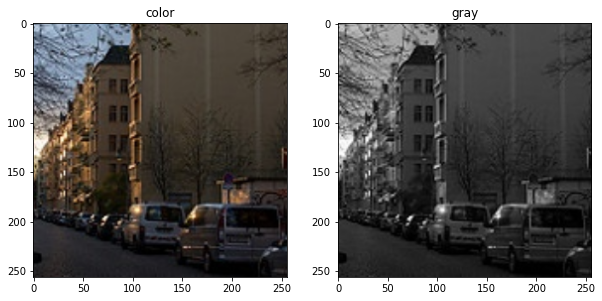

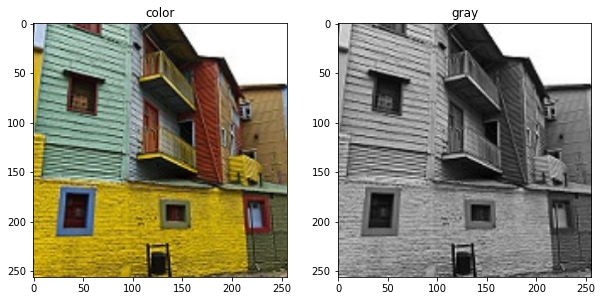

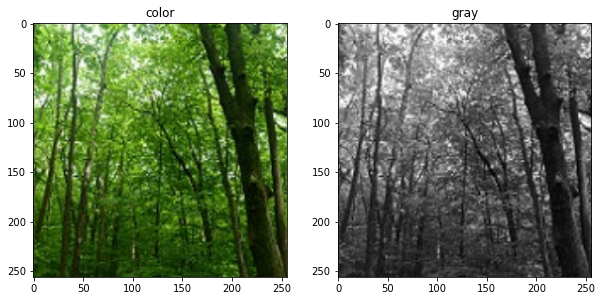

In [6]:
plot_images(3)

In [7]:
def encoder_layer(input_layer, filters, bn=True, dropout_rate=0.0):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4, 4), strides=(2, 2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    if dropout_rate > 0:
        x = tensorflow.keras.layers.Dropout(dropout_rate)(x)
    return x

def decoder_layer(input_layer, skip_input, filters, dropout_rate=0.0):
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4, 4), strides=(2, 2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    if dropout_rate > 0:
        x = tensorflow.keras.layers.Dropout(dropout_rate)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [8]:
import tensorflow
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Encoder layers
    e1 = encoder_layer(inputs, 64, bn=False)  # (bs, 128, 128, 64)
    e2 = encoder_layer(e1, 128)  # (bs, 64, 64, 128)
    e3 = encoder_layer(e2, 256)  # (bs, 32, 32, 256)
    e4 = encoder_layer(e3, 512)  # (bs, 16, 16, 512)
    e5 = encoder_layer(e4, 512)  # (bs, 8, 8, 512)
    e6 = encoder_layer(e5, 512)  # (bs, 4, 4, 512)
    e7 = encoder_layer(e6, 512)  # (bs, 2, 2, 512)
    e8 = encoder_layer(e7, 512)  # (bs, 1, 1, 512)

    # Decoder layers
    d1 = decoder_layer(e8, e7, 512)  # (bs, 2, 2, 1024)
    d2 = decoder_layer(d1, e6, 512)  # (bs, 4, 4, 1024)
    d3 = decoder_layer(d2, e5, 512)  # (bs, 8, 8, 1024)
    d4 = decoder_layer(d3, e4, 512)  # (bs, 16, 16, 1024)
    d5 = decoder_layer(d4, e3, 256)  # (bs, 32, 32, 512)
    d6 = decoder_layer(d5, e2, 128)  # (bs, 64, 64, 256)
    d7 = decoder_layer(d6, e1, 64)  # (bs, 128, 128, 128)

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)

    x = d7
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.Concatenate()([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = encoder_layer(x, 64, bn=False)  # (bs, 128, 128, 64)
    down2 = encoder_layer(down1, 128)  # (bs, 64, 64, 128)
    down3 = encoder_layer(down2, 256)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [10]:
generator = Generator()
discriminator = Discriminator()

In [11]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [12]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

 

In [13]:
def fit(train_ds, epochs):
  for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)

In [14]:
fit(tf.data.Dataset.zip((gray_dataset, color_dataset)),epochs = 10)

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


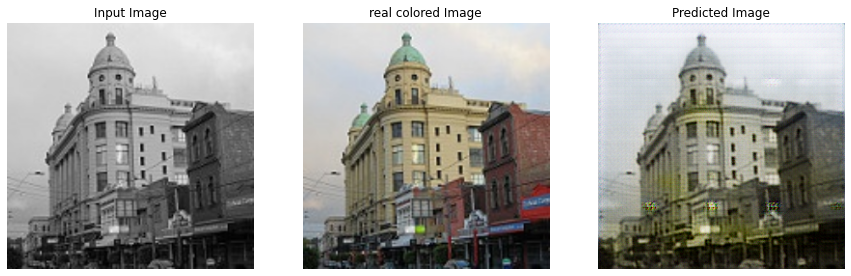

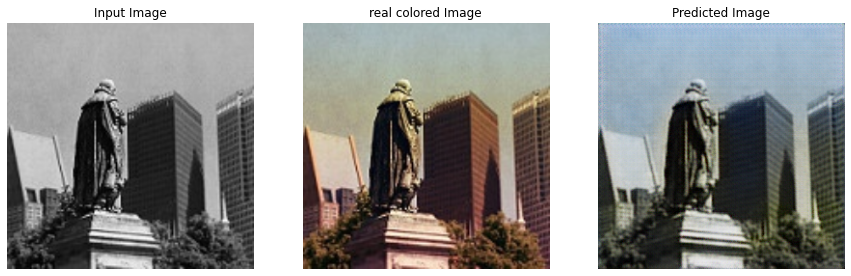

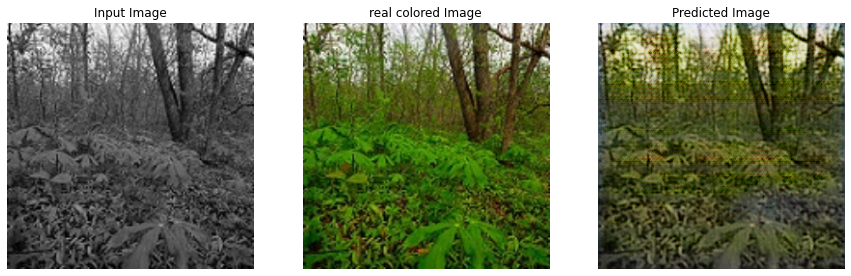

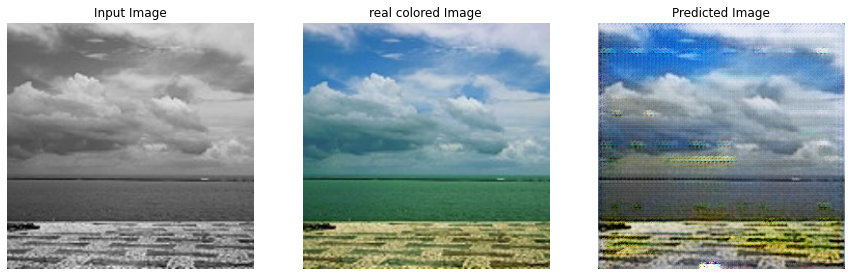

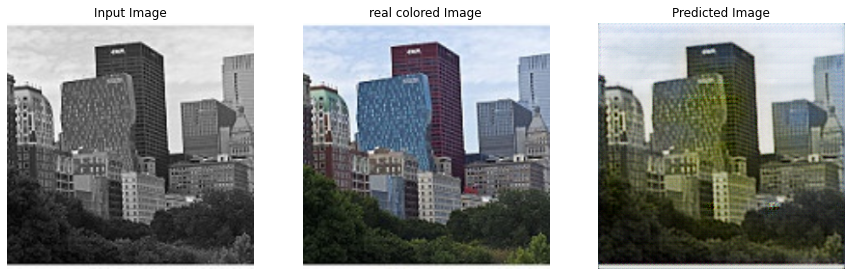

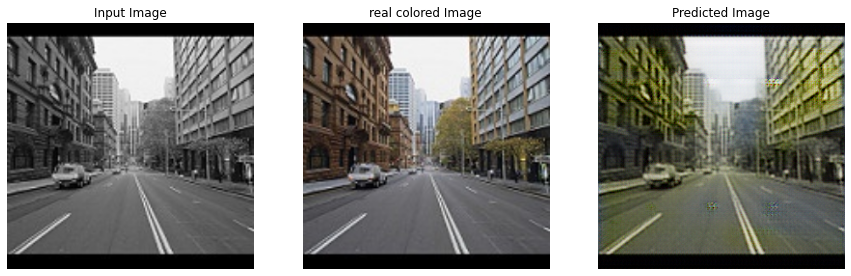

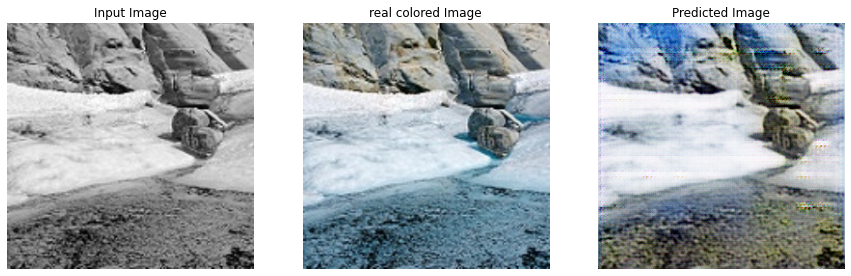

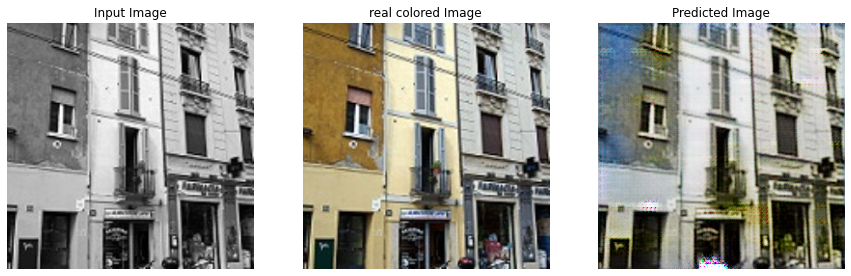

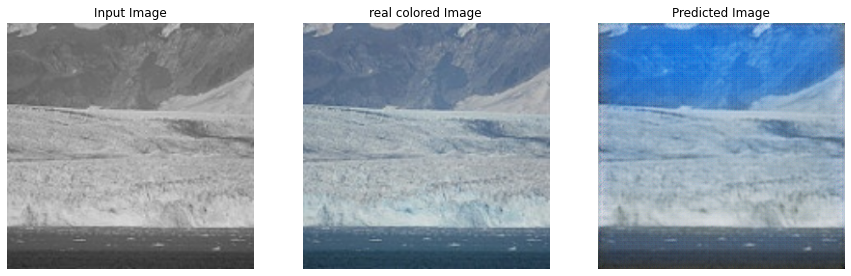

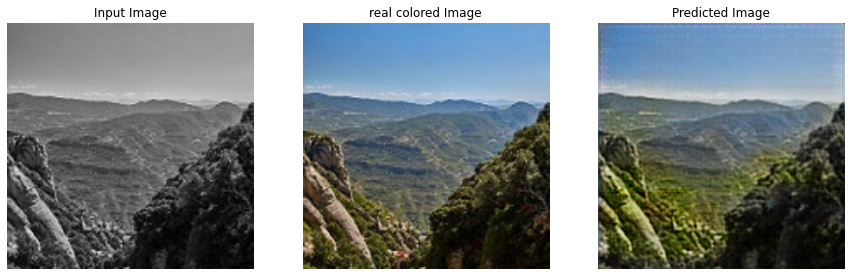

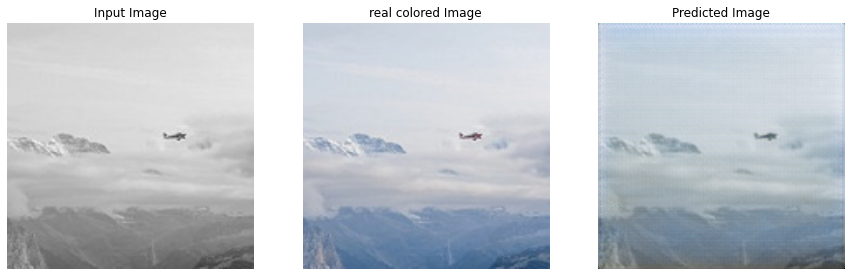

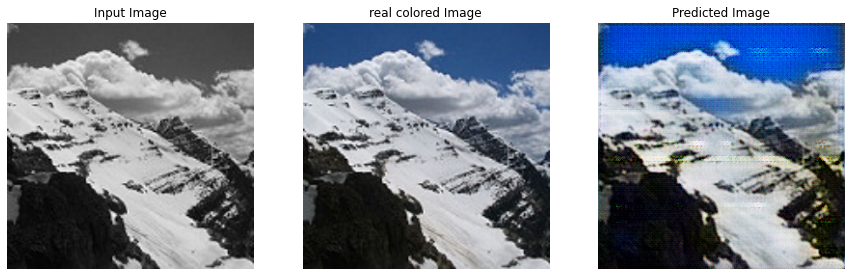

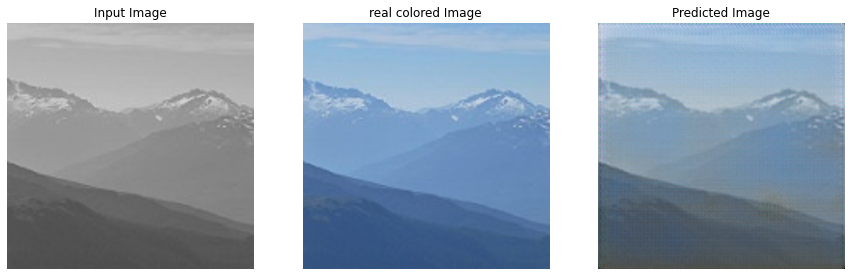

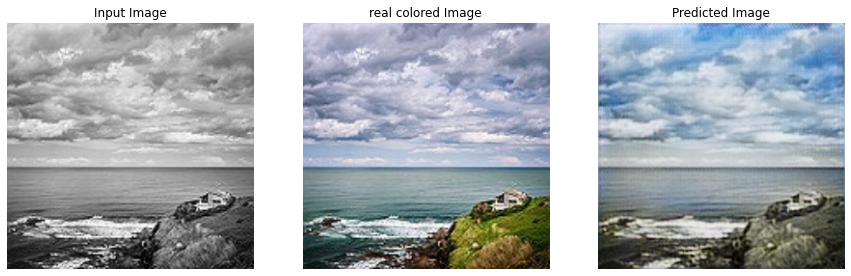

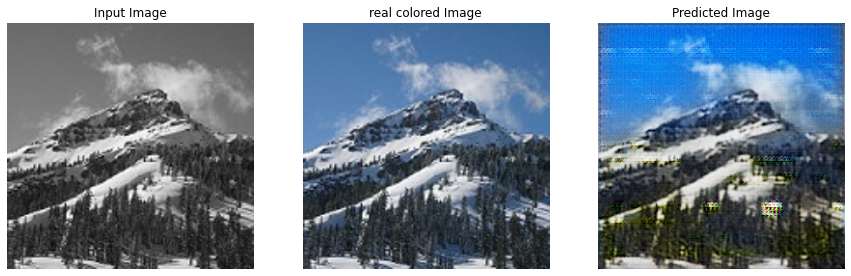

In [16]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'real colored Image', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)).take(15):
  generate_images(generator, example_input, example_target)
